In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [3]:
url = 'https://bnonews.com/index.php/2020/02/the-latest-coronavirus-cases/'
driver.get(url)
content = driver.page_source


### Extract date time

In [4]:
soup =BeautifulSoup(content, 'lxml')

In [5]:
data = soup.findAll(text=re.compile("Last update: .+"))
data

['Last update: 26 February 2020 at 5:30 p.m. ET']

In [6]:
m = re.search("Last update: (\d+ \w+ 202\d) at (\d+:\d+ [apAP].*[mM])", data[0])
data_date_time = ' '.join([m.group(1), m.group(2)])
data_date_time = re.sub("[\.]","",data_date_time)
data_date_time = datetime.strptime(data_date_time, '%d %B %Y %I:%M %p').strftime('%Y-%m-%d %H:%M')
data_date_time

'2020-02-26 17:30'

### Dataframes

In [7]:

dfs = pd.read_html(content)

In [8]:
len(dfs)
dfs[1]

,0,1,2,3,4
0,OTHER PLACES,Cases,Deaths,Notes,Links
1,Diamond Princess,705,4,"36 serious, 10 recovered",Source
2,South Korea,1261,12,"13 serious, 5 critical, 24 recovered",Source
3,Italy,453,12,"19 serious, 3 recovered",Source
4,Japan,172*,3,"13 serious, 23 recovered",Source
5,Iran,139,19,NaN,Source
6,Singapore,93,0,"7 critical, 58 recovered",Source
7,Hong Kong,89,2,"4 critical, 2 serious, 18 recovered",Source
8,United States,60,0,6 recovered,Source
9,Thailand,40,0,"2 serious, 15 recovered",Source


### International

In [9]:

df_intl =dfs[1]
df_intl.columns=['international', 'cases', 'd1', 'd2', 'd3']
df_intl

,international,cases,d1,d2,d3
0,OTHER PLACES,Cases,Deaths,Notes,Links
1,Diamond Princess,705,4,"36 serious, 10 recovered",Source
2,South Korea,1261,12,"13 serious, 5 critical, 24 recovered",Source
3,Italy,453,12,"19 serious, 3 recovered",Source
4,Japan,172*,3,"13 serious, 23 recovered",Source
5,Iran,139,19,NaN,Source
6,Singapore,93,0,"7 critical, 58 recovered",Source
7,Hong Kong,89,2,"4 critical, 2 serious, 18 recovered",Source
8,United States,60,0,6 recovered,Source
9,Thailand,40,0,"2 serious, 15 recovered",Source


In [10]:
df_intl.columns = df_intl.columns.map(str.lower)


#### Cases

In [11]:
df_intl_cases = df_intl[['international', 'cases']].set_index('international').T
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [re.sub('[^\d]+', '', x)  for x in row ])
df_intl_cases = df_intl_cases.apply(lambda row: 
                   [int(x) if x!='' else 0  for x in row ])

In [12]:
df_intl_cases = df_intl_cases.drop(['TOTAL'], axis=1)

In [13]:
# add date time column
df_intl_cases.insert(0, 'datetime', data_date_time)
df_intl_cases

international,datetime,OTHER PLACES,Diamond Princess,South Korea,Italy,Japan,Iran,Singapore,Hong Kong,United States,...,Croatia,Switzerland,Algeria,Brazil,Greece,Pakistan,North Macedonia,Georgia,Norway,Romania
cases,2020-02-26 17:30,0,705,1261,453,172,139,93,89,60,...,3,1,1,1,1,2,1,1,1,1


#### Save to file

In [14]:
from pathlib import Path
csv_file = 'data/bnonews-international.csv'

df = df_intl_cases

if Path(csv_file).exists():
    old_df = pd.read_csv(csv_file, parse_dates=True)

    df = pd.concat([old_df, df], sort=True)
df = df.set_index('datetime').fillna(0)

In [15]:

df = df.loc[~df.index.duplicated(keep='first')]
df.sort_values(by=['datetime'], inplace=True)


for col in df.columns:
    df[col] = df[col].astype('int')
    
df

,Afghanistan,Algeria,Australia,Austria,Bahrain,Belgium,Brazil,Cambodia,Canada,Croatia,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,United Kingdom,United States,Vietnam
datetime,,,,,,,,,,,,,,,,,,,,,
2020-02-06 08:03,0,0,15,0,0,1,0,1,5,0,...,1,1,1,0,0,25,5,2,12,12
2020-02-06 08:19,0,0,15,0,0,1,0,1,5,0,...,1,1,1,0,0,25,5,3,12,12
2020-02-06 09:01,0,0,15,0,0,1,0,1,5,0,...,1,1,1,0,0,25,5,3,12,12
2020-02-06 09:46,0,0,15,0,0,1,0,1,5,0,...,1,1,1,0,0,25,5,3,12,12
2020-02-06 17:56,0,0,15,0,0,1,0,1,7,0,...,1,1,1,0,0,25,5,3,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-26 06:46,1,1,23,2,26,1,1,1,11,2,...,11,1,1,1,32,40,13,13,57,16
2020-02-26 15:14,1,1,23,2,26,1,1,1,12,3,...,12,1,2,1,32,40,13,13,60,16
2020-02-26 15:52,1,1,23,2,33,1,1,1,12,3,...,13,1,2,1,32,40,13,13,60,16


In [16]:

df.to_csv(csv_file, index=True)


Text(0.5, 0, 'Number of cases, sampled at 2020-02-26 17:30')

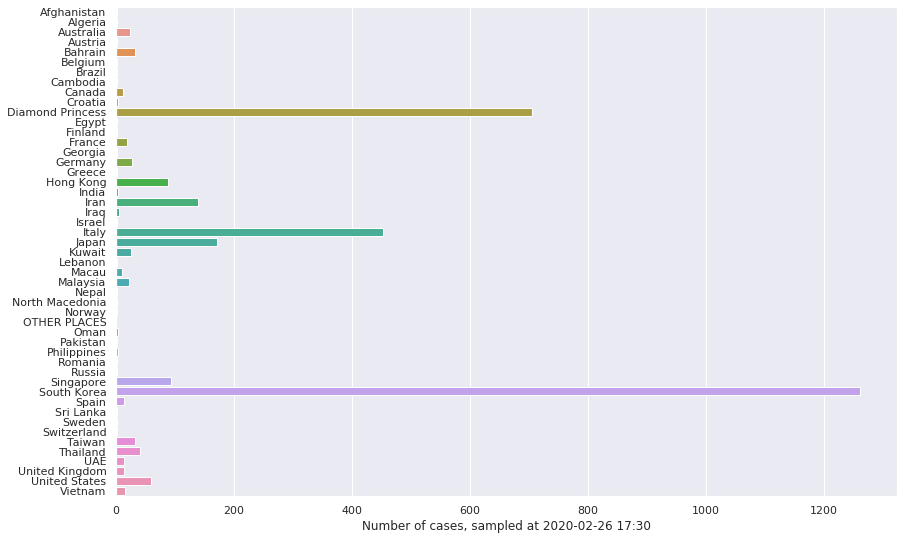

In [17]:
import seaborn as sns

series = df.iloc[-1]

sns.set(rc={'figure.figsize':(14,9)})
ax = sns.barplot(y=series.index, x=series)
ax.set_xlabel('Number of cases, sampled at '+series.name)



In [18]:
png_file='images/bnonews-international.png'
fig = ax.get_figure()
fig.savefig(png_file)